JAX is a python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.

In [4]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import lax
import matplotlib.pyplot as plt

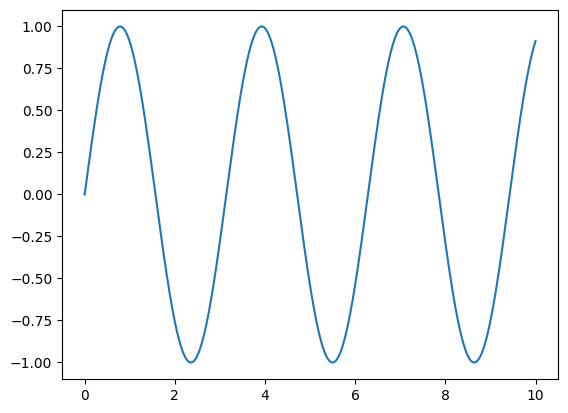

In [5]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [7]:
size = 10
index = 0
value = 23

x = np.arange(size)
print(x)
x[index] = value
print(x)

#In JAX we delete immutable arrays, so we need to create a new array
x = jnp.arange(size)
print(x)
x[index] = value

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]
[0 1 2 3 4 5 6 7 8 9]


TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

If the input value x of x.at[idx].set(y) is not reused, you can tell JAX to optimize the array update to occur in-place.

In [8]:
jax_array = jnp.zeros((3, 3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)

print('Original array unchanged:', jax_array)
print('Updated array:', updated_array)

print('New array post addition')
new_jax_array = jax_array.at[::2, :1].add(7.0)
print(new_jax_array)

Original array unchanged: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Updated array: [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]
New array post addition
[[7. 0. 0.]
 [0. 0. 0.]
 [7. 0. 0.]]


JAX handles random numbers differently (for the same reason as above)

In [9]:
seed = 0
key = jax.random.PRNGKey(seed)

x = jax.random.normal(key, (10,)) #You need to explicitly pass the key i.e. PRNGKey
print(type(x), x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [10]:
#JAX is AI accelerator agnostic. Same code runs everywhere!
size = 3000

#Data is automatically pushed to AI accelerator (GPU/TPU)
x_jnp = jax.random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

print('[1] GPU')
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
print('[2] Pure numpy (CPU)')
%timeit np.dot(x_np, x_np.T)
print('[3] GPU + data transfer')
%timeit jnp.dot(x_np, x_np.T).block_until_ready()

x_np_device = jax.device_put(x_np) #Push numpy explicitly to GPU
print('[4] GPU + explicit pre-data transfer (like [1] but explicit)')
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()

[1] GPU
109 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[2] Pure numpy (CPU)
26.9 ms ± 731 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[3] GPU + data transfer
110 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[4] GPU + explicit pre-data transfer (like [1] but explicit)
113 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<h1>JAX Transofrmation functions</h1>
$jit$ compiles your functions using XLA and caches them to reach the best speed

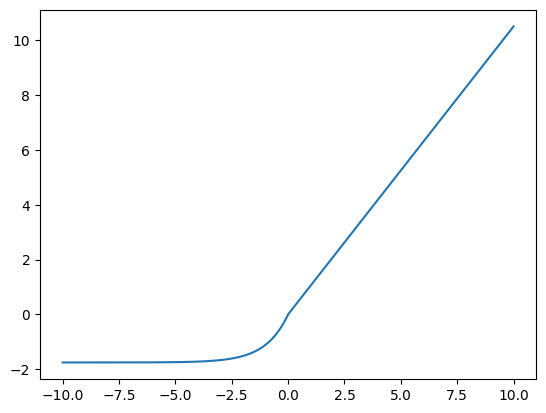

Non-jit
1.11 ms ± 23.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Jit
299 μs ± 5.46 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y=fn(x)
    plt.plot(x, y)
    plt.show()

def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jax.jit(selu) #Let's jit it

visualize_fn(selu) #Visualize selu

data = jax.random.normal(key, (1000000,)) #Benchmark non-jit vs jit version

print('Non-jit')
%timeit selu(data).block_until_ready()
print('Jit')
%timeit selu_jit(data).block_until_ready()

<h1>Automatic differentiation in JAX</h1>
JAX augments numpy and python code with function transformations which make it trivial to perform operations common in machine learning programs. The function df = jax.grad(f, argnums = 0) takes the callable object f and returns another callable object, df, evaluating the gradient of f w.r.t. the argument(s) of index(es) argnums.

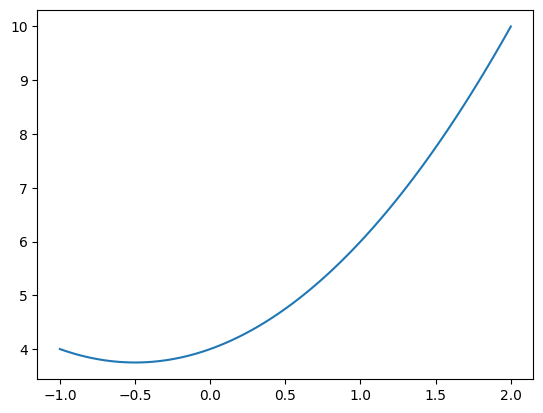

f at x=1.0: 6.0
df/dx at x=1.0: 3.0
d2f/dx2 at x=1.0: 2.0
d3f/dx3 at x=1.0: 0.0


In [14]:
x = 1.0

f = lambda x: x**2 + x + 4
visualize_fn(f, l=-1, r=2, n=100)

dfdx = jax.grad(f) #2x + 1
d2fdx = jax.grad(dfdx) #2
d3fdx = jax.grad(d2fdx) #0

print(f'f at x={x}:', f(x))
print(f'df/dx at x={x}:', dfdx(x))
print(f'd2f/dx2 at x={x}:', d2fdx(x))
print(f'd3f/dx3 at x={x}:', d3fdx(x))

<h3>What if we had two inputs?</h3>
We use jacrev and jacfwd:<br>
These two functions compute the same values (up to machine numerics), but differ in their implementation: jacfwd user forward-mode automatic differentiation, which is more efficient for "tall" Jacobian matrices, while jacre uses reverse-mode, which is more efficient for
"wide" Jacobian matrices. For matrices that are near-square, jacfwd probably has an edge over jacrev.
To implement hessian, we could have used jacfwd (jacrev(f)) or jacrev(jacfwd(f)) or any other composition of the two. But forward-over-reverse is typically the most efficient. That's because in the inner Jacobian computation we're often differentiating a function wide Jacobian (maybe like a loss function f: R" → R), while in the outer Jacobian computation we're differentiating a function with a square Jacobian (since Vf: R" → R"), which is where forward-mode wins out.

In [15]:
f = lambda x, y: x**2 + y**2

def eval_hessian(f):
    return jax.jit(jax.jacfwd(jax.jacrev(f, argnums=(0, 1)), argnums=(0, 1)))

jacobian = jax.jacrev(f, argnums=(0, 1))(1.0, 1.0)
hessian = eval_hessian(f)(1.0, 1.0)
print('Jacobian:', jacobian)
print('Hessian:', hessian)

Jacobian: (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Hessian: ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


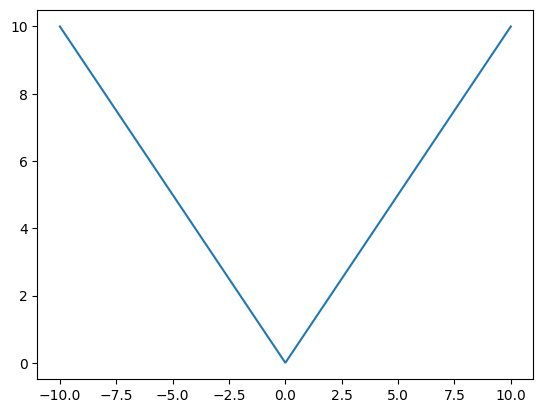

dfdx(0.0) = 1.00000000000000000e+00
dfdx(+1e-5) = 1.00000000000000000e+00
dfdx(-1e-5) = -1.00000000000000000e+00


In [16]:
#Edge case |x|, how does JAX handle it?

f = lambda x: abs(x)
visualize_fn(f)

dfdx = jax.grad(f)
print(f"dfdx(0.0) = {dfdx(0.0):.17e}")
print(f"dfdx(+1e-5) = {dfdx(+1e-5):.17e}")
print(f"dfdx(-1e-5) = {dfdx(-1e-5):.17e}")

<h1>Vectorize functions using vmap()</h1>